In [1]:
cd ../input

/kaggle/input


In [2]:
import os
import tensorflow as tf
import tensorflow_io as tfio

FR = os.path.join('data-fr')
EN = os.path.join('data-en')
DE = os.path.join('data-de')
ES = os.path.join('data-es')
fr = tf.data.Dataset.list_files(FR + '/*.wav')
en = tf.data.Dataset.list_files(EN + '/*.wav')
de = tf.data.Dataset.list_files(DE + '/*.wav')
es = tf.data.Dataset.list_files(ES + '/*.wav')


frMapped = tf.data.Dataset.zip((fr, tf.data.Dataset.from_tensor_slices(tf.ones(len(fr)))))
enMapped = tf.data.Dataset.zip((en, tf.data.Dataset.from_tensor_slices(tf.zeros(len(en)))))
deMapped = tf.data.Dataset.zip((de, tf.data.Dataset.from_tensor_slices(tf.ones(len(de))*2)))
esMapped = tf.data.Dataset.zip((es, tf.data.Dataset.from_tensor_slices(tf.ones(len(es))*3)))

data = frMapped.concatenate(enMapped)
data = data.concatenate(deMapped)
data = data.concatenate(esMapped)

2023-01-21 19:15:34.334958: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

def preprocess(file_path, label):
     # Load audio file
    wav = load_wav_16k_mono(file_path)
    # Pad or truncate the audio file to 5 seconds
    wav = wav[:80000]
    zero_padding = tf.zeros([80000] - tf.shape(wav), dtype=tf.float32)
    # Concatenate audio with padding so that all audio clips will be of the
    wav = tf.concat([zero_padding, wav], 0)
    # Normalize the audio file
    # Do I really need to normalize ???
    wav = wav / tf.math.reduce_max(wav)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    # Stride of 50% (ratio between frame_length and frame_step)
    # frame_length: 320 = 20ms with 16kHz pooling rate
    # frame_step: 32 = 2ms with 16kHz pooling rate
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=4000)
data = data.batch(32)
data = data.prefetch(16)

train = data.take(3200)
test = data.skip(3200).take(800)

2023-01-21 19:15:42.310874: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


In [4]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(2491, 257, 1)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2489, 255, 32)     320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1244, 127, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1244, 127, 32)     128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1242, 125, 32)     9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 621, 62, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 621, 62, 32)       128       
_________________________________________________________________
flatten (Flatten)            (None, 1232064)           0

In [5]:
print("Time to train the Model")
# Train the model
# --------------------------------------------------------------
history = model.fit(train, epochs=4, validation_data=test, verbose=1)
# --------------------------------------------------------------

Time to train the Model
Epoch 1/4


2023-01-21 19:16:05.285743: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-21 19:16:15.591257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 237 of 4000
2023-01-21 19:16:25.562612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 475 of 4000
2023-01-21 19:16:35.555652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 719 of 4000
2023-01-21 19:16:45.561185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 953 of 4000
2023-01-21 19:16:55.568221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1196 of 4000
2023-01-21 19:17:05.543646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up s

125/125 [==============================] - 882s 6s/step - loss: 11.1539 - sparse_categorical_accuracy: 0.2833
Epoch 2/4
125/125 [==============================] - 706s 6s/step - loss: 1.2424 - sparse_categorical_accuracy: 0.3692
Epoch 3/4
125/125 [==============================] - 711s 6s/step - loss: 1.3430 - sparse_categorical_accuracy: 0.2903
Epoch 4/4
125/125 [==============================] - 707s 6s/step - loss: 1.2261 - sparse_categorical_accuracy: 0.3655


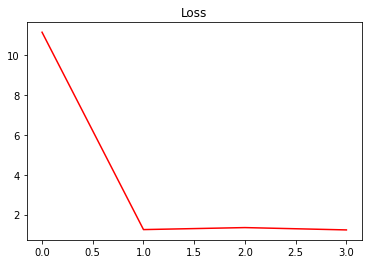

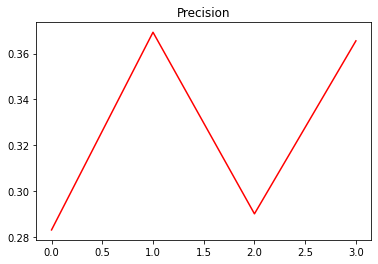

In [7]:
from matplotlib import pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], 'r')
plt.show()
plt.title('Precision')
plt.plot(history.history['sparse_categorical_accuracy'], 'r')
plt.show()

In [18]:
cd ../working

/kaggle/working


In [ ]:
# Save the model
model.save('model.h5')

In [19]:
from tensorflow import keras
model = keras.models.load_model('../input/models/model.h5')